<a href="https://colab.research.google.com/github/Yoshiki0418/-Generation-AI/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F
from torch import optim

In [2]:
# FashionMNISTデータでVAEを試す
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.82MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 166kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.73MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.31MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



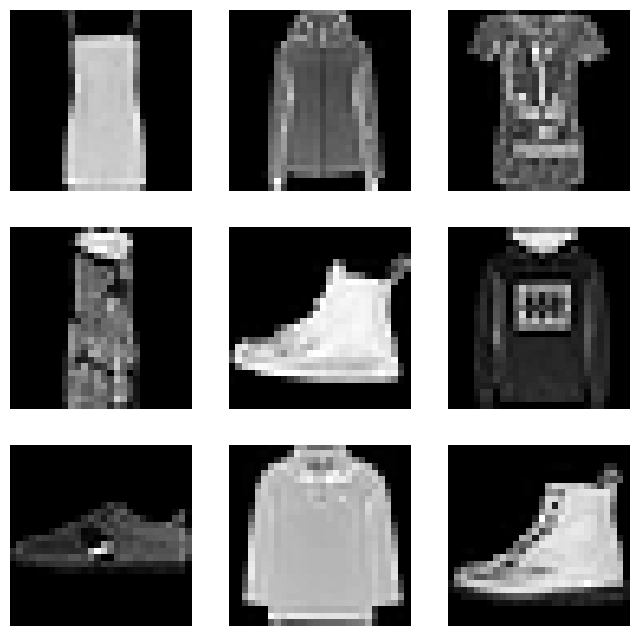

In [3]:
# 入力画像を描画する
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, rows*cols + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [4]:
# ハイパーパラメータ
image_size = 28
mid_dim1 = 256
mid_dim2 = 512
n_noise = 100 # ノイズ数
lr = 0.0002
epochs = 40
batch_size = 64

In [5]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

## GANを構築

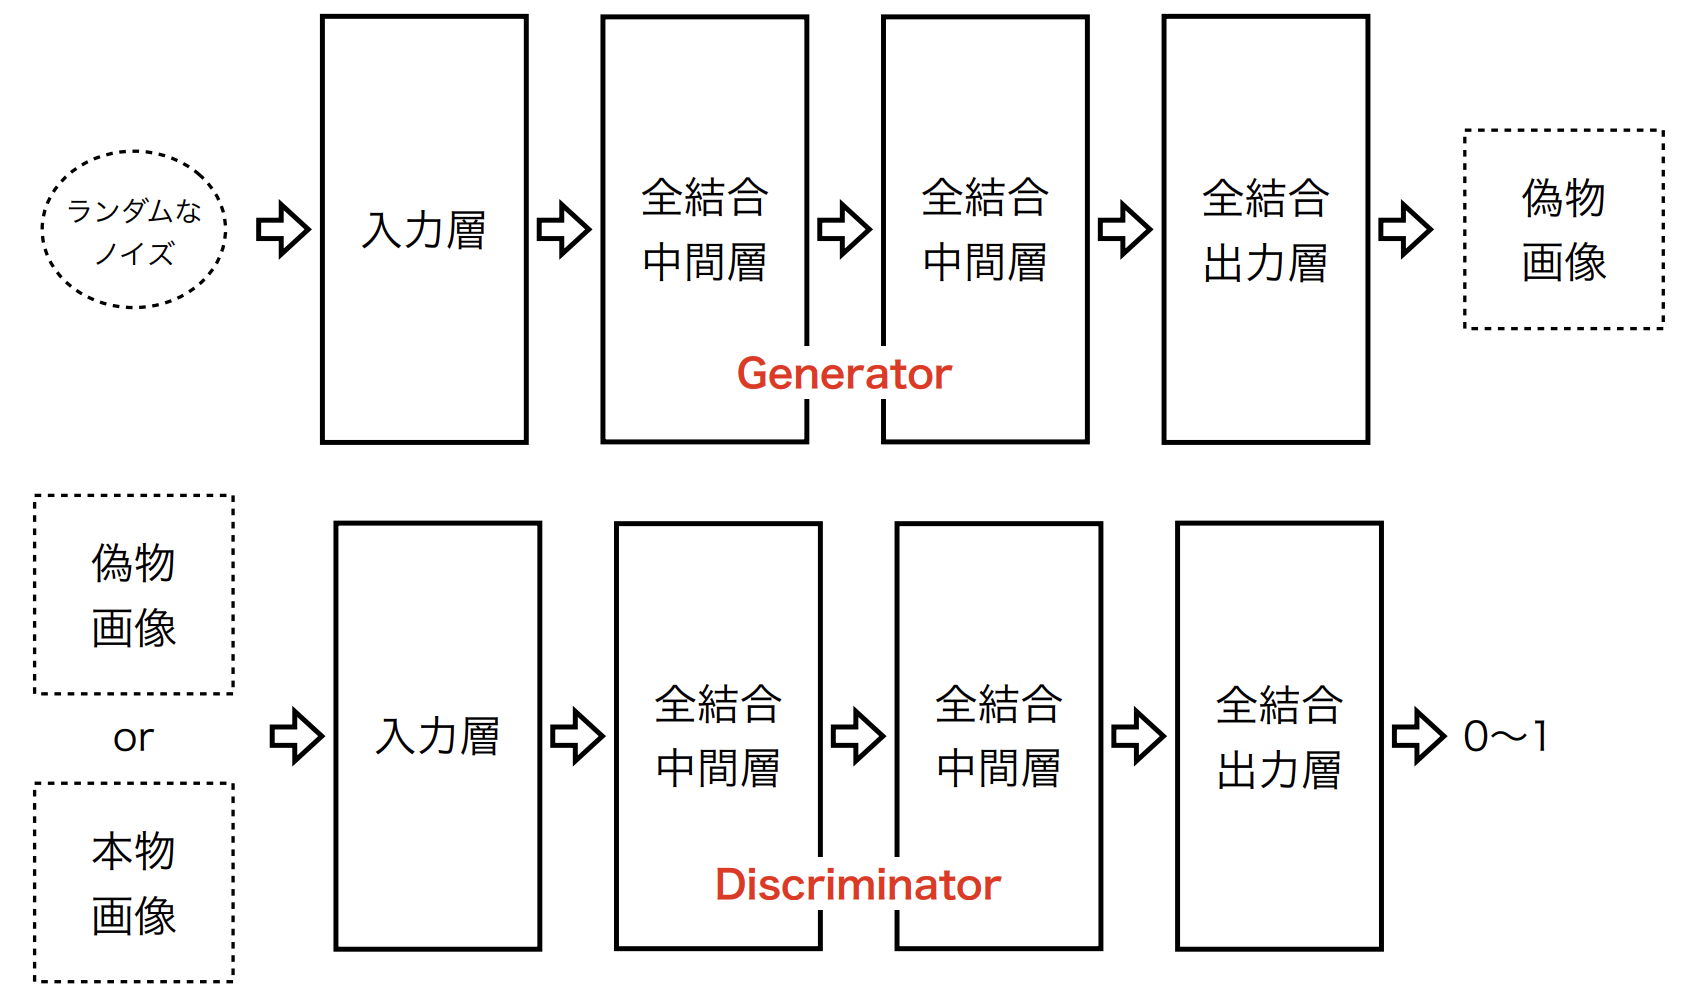

### Generatorの構築

In [6]:
class Generator(nn.Module):
  def __init__(self, image_size, n_noise, mid_dim1, mid_dim2):
    super().__init__()
    self.image_size = self.size_checker(image_size)
    self.block1 = nn.Linear(n_noise, mid_dim1)
    self.block2 = nn.Linear(mid_dim1, mid_dim2)

    self.head = nn.Linear(mid_dim2, self.image_size)

    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.relu(self.block1(x))
    x = self.relu(self.block2(x))
    out = F.tanh(self.head(x))
    return out

  def size_checker(self, image_size):
    if isinstance(image_size, tuple):
      return image_size[0] * image_size[1]
    else:
      return image_size * image_size

In [7]:
generator = Generator(image_size, n_noise, mid_dim1, mid_dim2)
generator.cuda()  # GPU対応
print(generator)

Generator(
  (block1): Linear(in_features=100, out_features=256, bias=True)
  (block2): Linear(in_features=256, out_features=512, bias=True)
  (head): Linear(in_features=512, out_features=784, bias=True)
  (relu): ReLU()
)


### Discriminatorの構築

In [8]:
class Discriminator(nn.Module):
  def __init__(self, image_size, mid_dim1, mid_dim2):
    super().__init__()
    self.image_size = self.size_checker(image_size)
    self.block1 = nn.Linear(self.image_size, mid_dim2)
    self.block2 = nn.Linear(mid_dim2, mid_dim1)

    self.head = nn.Linear(mid_dim1, 1)

    self.sigmoid = nn.Sigmoid()
    self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.leaky_relu(self.block1(x))
    x = self.leaky_relu(self.block2(x))
    out = self.sigmoid(self.head(x))
    return out

  def size_checker(self, image_size):
    if isinstance(image_size, tuple):
      return image_size[0] * image_size[1]
    else:
      return image_size * image_size

In [9]:
discriminator = Discriminator(image_size, mid_dim1, mid_dim2)
discriminator.cuda()  # GPU対応
print(discriminator)

Discriminator(
  (block1): Linear(in_features=784, out_features=512, bias=True)
  (block2): Linear(in_features=512, out_features=256, bias=True)
  (head): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)


### 画像の生成

In [10]:
def generate_images(i, n_noise, image_size):
    # 画像の生成
    rows = 16
    cols = 16
    noise = torch.randn(rows * cols, n_noise).cuda()  # GPUに移動
    generator.cuda()  # generatorモデルもGPUに移動
    imgs = generator(noise)
    imgs = imgs.cpu().detach().numpy()  # 結果をCPUに戻す

    img_size_spaced = image_size + 2
    matrix_image = np.zeros((img_size_spaced * rows, img_size_spaced * cols))

    # 生成された画像を並べて一枚の画像にする
    for r in range(rows):
        for c in range(cols):
            img = imgs[r * cols + c].reshape(image_size, image_size)
            top = r * img_size_spaced
            left = c * img_size_spaced
            matrix_image[top: top + image_size, left: left + image_size] = img

    plt.figure(figsize=(8, 8))
    plt.imshow(matrix_image, cmap="Greys_r", vmin=0.0, vmax=1.0)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 軸目盛りのラベルと線を消す
    plt.show()

In [11]:
def count_correct(y, t):
  correct = torch.sum((torch.where(y<0.5, 0, 1) ==  t).float())
  return correct.item()

### 学習

Epochs: 0
Error_fake: 0.6138006539931938 Acc_fake: 0.7315166666666667
Error_real: 0.5351870551959538 Acc_real: 0.68325


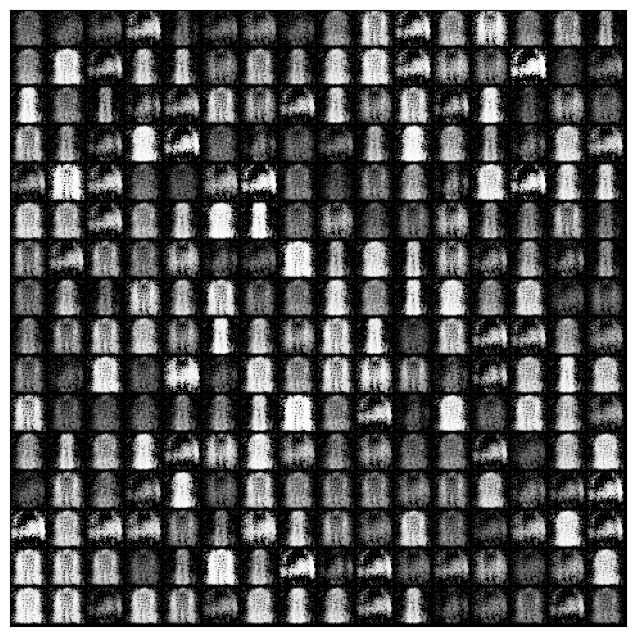

Epochs: 10
Error_fake: 0.6830085956338626 Acc_fake: 0.5796
Error_real: 0.6925408517373904 Acc_real: 0.47856666666666664


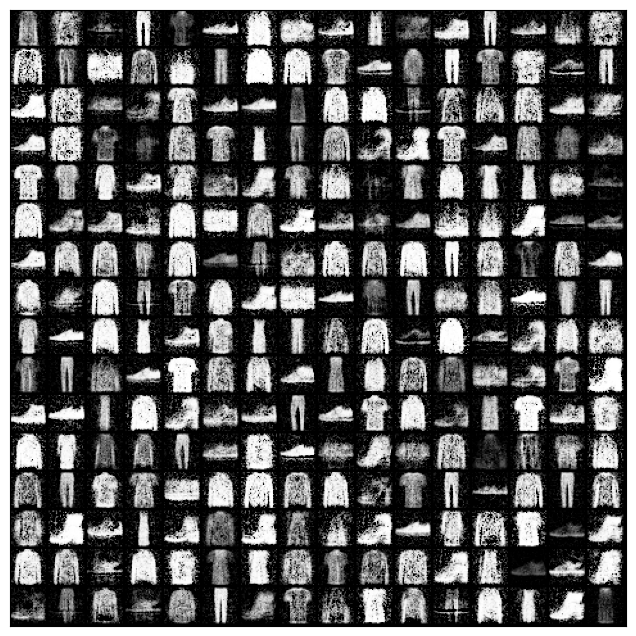

Epochs: 20
Error_fake: 0.687768803667158 Acc_fake: 0.55565
Error_real: 0.6883556241673956 Acc_real: 0.5163333333333333


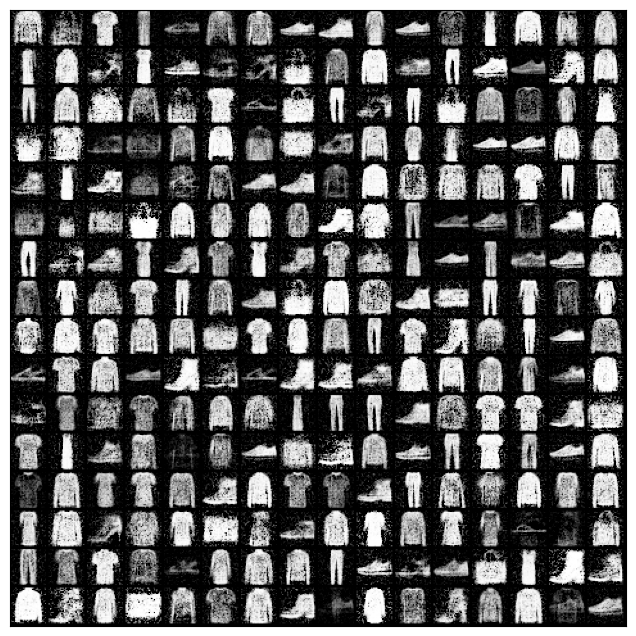

Epochs: 30
Error_fake: 0.6815871828273415 Acc_fake: 0.5761833333333334
Error_real: 0.6824004452492891 Acc_real: 0.54


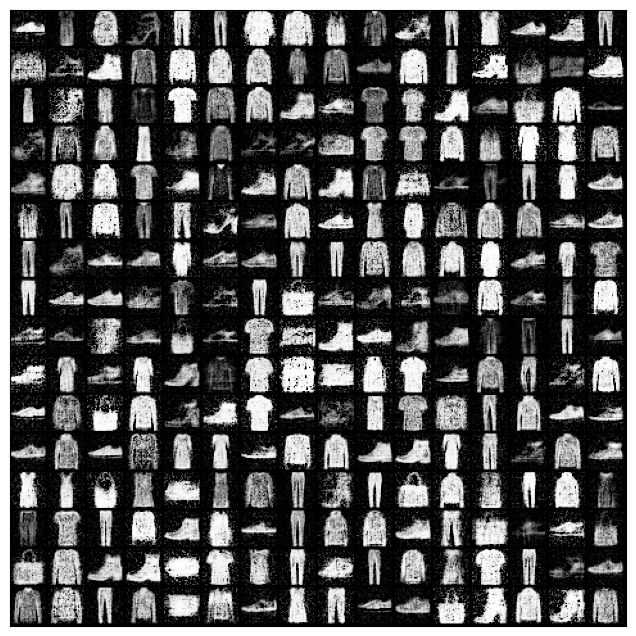

In [12]:
# 二値の交差エントロピー誤差関数
loss_func = nn.BCELoss()

# Adam
optimizer_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# ログ
error_record_fake = []  # 偽物画像の誤差記録
acc_record_fake = []  # 偽物画像の精度記録
error_record_real = []  # 本物画像の誤差記録
acc_record_real = []  # 本物画像の精度記録

# -------------------------------------------
#             GAN の学習
# -------------------------------------------
generator.train()
discriminator.train()
for i in range(epochs):
  loss_fake = 0
  correct_fake = 0
  loss_real = 0
  correct_real = 0
  n_total = 0
  for j, (x,_) in enumerate(train_loader):
    n_total += x.size()[0]

    # ノイズからGeneratorで画像を生成し、Discriminatorに偽物画像を与えて訓練
    noise = torch.randn(x.size()[0], n_noise).cuda()
    fake_imgs = generator(noise)
    y = torch.zeros(x.size()[0], 1).cuda() # 正解ラベルを0とする
    y_pred = discriminator(fake_imgs)
    loss = loss_func(y_pred, y)
    optimizer_disc.zero_grad()
    loss.backward()
    optimizer_disc.step()
    loss_fake += loss.item()
    correct_fake += count_correct(y_pred, y)

    # Discriminatorに本物画像を与えて訓練
    real_imgs = x.cuda()
    real_imgs = real_imgs.view(real_imgs.size(0), -1)
    y = torch.ones(x.size()[0], 1).cuda() # 正解ラベルを1とする
    y_pred = discriminator(real_imgs)
    loss = loss_func(y_pred, y)
    optimizer_disc.zero_grad()
    loss.backward()
    optimizer_disc.step()
    loss_real += loss.item()
    correct_real += count_correct(y_pred, y)

    # Generatorを訓練
    noise = torch.randn(x.size()[0]*2, n_noise).cuda() # Discriminatorは偽物と本物でバッチサイズを２回分学習しているので、こちらのバッチサイズは2倍にしてバランスを整える
    fake_imgs = generator(noise)
    y = torch.ones(x.size()[0]*2, 1).cuda()
    y_pred = discriminator(fake_imgs)
    loss = loss_func(y_pred, y)
    optimizer_gen.zero_grad()
    loss.backward()
    optimizer_gen.step()

  loss_fake /= j+1  # 誤差
  error_record_fake.append(loss_fake)
  acc_fake = correct_fake / n_total  # 精度
  acc_record_fake.append(acc_fake)

  loss_real /= j+1  # 誤差
  error_record_real.append(loss_real)
  acc_real = correct_real / n_total  # 精度
  acc_record_real.append(acc_real)

  # 一定間隔で誤差と精度、および生成された画像を表示
  if i % 10 == 0:
      print ("Epochs:", i)
      print ("Error_fake:", loss_fake , "Acc_fake:", acc_fake)
      print ("Error_real:", loss_real , "Acc_real:", acc_real)
      generate_images(i, n_noise, image_size)

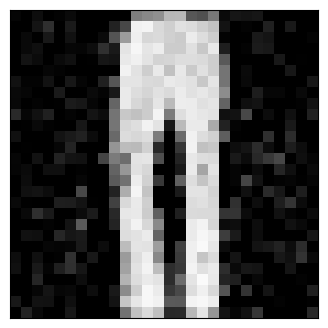

In [19]:
# 1枚の画像を生成
noise = torch.randn(1, n_noise).cuda()  # 1つのノイズベクトルを生成し、GPUに移動
generator.cuda()  # generatorモデルもGPUに移動
img = generator(noise)
img = img.cpu().detach().numpy().reshape(image_size, image_size)  # 結果をCPUに戻し、形状を変換

# 生成画像の表示
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap="Greys_r", vmin=0.0, vmax=1.0)
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

In [1]:
# -- 誤差の推移 --
plt.plot(range(len(error_record_fake)), error_record_fake, label="Error_fake")
plt.plot(range(len(error_record_real)), error_record_real, label="Error_real")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# -- 正解率の推移 --
plt.plot(range(len(acc_record_fake)), acc_record_fake, label="Acc_fake")
plt.plot(range(len(acc_record_real)), acc_record_real, label="Acc_real")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

NameError: name 'plt' is not defined